# Spam emails filter

## Data exploration

In [1]:
import os

cwd = os.getcwd()
DATA_DIR = os.path.join(cwd, "data")

The dataset is divided into examples of two groups of emails: `spam` and not spam `clean`.

In [2]:
os.listdir(DATA_DIR)

['spam', 'all', 'clean']

In [3]:
def get_filenames(dir_name):
    return [name for name in sorted(os.listdir(dir_name))]

In [4]:

clean_filesnames = get_filenames(os.path.join(DATA_DIR, 'clean'))
spam_filenames = get_filenames(os.path.join(DATA_DIR, 'spam'))


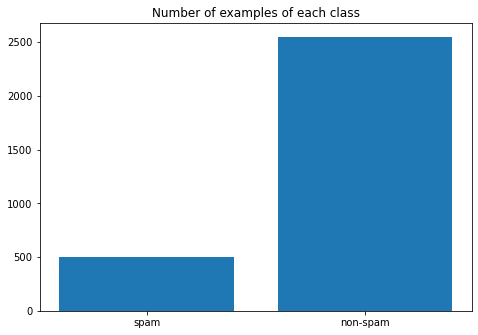

In [5]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(["spam", "non-spam"],[len(spam_filenames), len(clean_filesnames)])

plt.title("Number of examples of each class")
plt.show()

The dataset mostly consists of `non-spam` emails.

In [6]:
import email
import email.policy

ALL_EMAILS_DIR = os.path.join(DATA_DIR, "all")

def load_email(filename):
    with open(os.path.join(ALL_EMAILS_DIR, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [7]:
example_spam_email = load_email(spam_filenames[123])


Let's see an example of spam email.

In [8]:
print('Header Field Names:\n',example_spam_email.keys())

Header Field Names:
 ['Return-Path', 'Delivered-To', 'Received', 'Received', 'Received', 'Received', 'Received', 'From', 'To', 'X-Mailer', 'Content-Type', 'Message-Id', 'Subject', 'Sender', 'Errors-To', 'X-Beenthere', 'X-Mailman-Version', 'Precedence', 'List-Help', 'List-Post', 'List-Subscribe', 'List-Id', 'List-Unsubscribe', 'List-Archive', 'X-Original-Date', 'Date', 'Content-Transfer-Encoding', 'X-MIME-Autoconverted']


In [9]:

print('Subject:\n',example_spam_email['Subject'])


Subject:
 [scoop] Haberdar olun


In [10]:
print('Message Field Values:\n',example_spam_email.values())

Message Field Values:
 ['<sitescooper-talk-admin@lists.sourceforge.net>', 'zzzz@localhost.example.com', 'from localhost (localhost [127.0.0.1])\tby phobos.labs.example.com (Postfix) with ESMTP id 92C1843F9B\tfor <zzzz@localhost>; Mon, 26 Aug 2002 15:15:19 -0400 (EDT)', 'from phobos [127.0.0.1]\tby localhost with IMAP (fetchmail-5.9.0)\tfor zzzz@localhost (single-drop); Mon, 26 Aug 2002 20:15:19 +0100 (IST)', 'from usw-sf-list2.sourceforge.net (usw-sf-fw2.sourceforge.net    [216.136.171.252]) by dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id    g7QJ9ZZ05743 for <zzzz-scoop@jmason.org>; Mon, 26 Aug 2002 20:09:35 +0100', 'from usw-sf-list1-b.sourceforge.net ([10.3.1.13]    helo=usw-sf-list1.sourceforge.net) by usw-sf-list2.sourceforge.net with    esmtp (Exim 3.31-VA-mm2 #1 (Debian)) id 17jPEm-0001Sc-00; Mon,    26 Aug 2002 12:09:20 -0700', 'from [65.198.220.134] (helo=ejhvvet) by    usw-sf-list1.sourceforge.net with smtp (Exim 3.31-VA-mm2 #1 (Debian)) id    17jPDw-0006Aq-00 for <sitesc

In [11]:
print('Message Content:\n',example_spam_email.get_content())

Message Content:
 HABERDAR.COM - HABER VE MEDYA PORTALI
Art�k t�m haberleri sadece tek siteden takip edebileceksiniz. Haberdar.com a��ld�!
Haber ba�l�klar�, spor haberleri, teknoloji haberleri, k�lt�r ve sanat haberleri, internet haberleri, bilim ve uzay, 
sinema, sa�l�k...
Arad���n�z i�erik http://www.haberdar.com adresinde
Sadece t�klay�n ve haberdar olun

�������������������������������������������+,������X���'���u��9 ��8�y�������W\zYi����g�jw����~��DA���i������za�x���&��������������}�{�}�������������������������������������J+^��(�����d����x%��R���r�)z��jY��+-��(��~��{���m����X�������y�+���z����l�X��)���"����^��Z




## Data preparation

First we need to prepare the training and test `dataset` for our model.

In [12]:
print("Importing clean mails\n")
clean_emails = [load_email(email) for email in clean_filesnames]
print("\nImporting spam mails\n")
spam_emails = [load_email(email) for email in spam_filenames]


Importing clean mails


Importing spam mails



### Struture of emails

In [13]:
from collections import Counter

def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures


In [14]:
clean_structures = structures_counter(clean_emails)
print("Clean mails structure:\n", clean_structures)

Clean mails structure:
 Counter({'text/plain': 2453, 'multipart(text/plain, application/pgp-signature)': 72, 'multipart(text/plain, text/html)': 8, 'multipart(text/plain, text/plain)': 4, 'multipart(text/plain)': 3, 'multipart(text/plain, application/octet-stream)': 2, 'multipart(text/plain, text/enriched)': 1, 'multipart(text/plain, application/ms-tnef, text/plain)': 1, 'multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)': 1, 'multipart(text/plain, video/mng)': 1, 'multipart(text/plain, multipart(text/plain))': 1, 'multipart(text/plain, application/x-pkcs7-signature)': 1, 'multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)': 1, 'multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))': 1, 'multipart(text/plain, application/x-java-applet)': 1})


In [15]:
spam_structures = structures_counter(spam_emails)
print("Clean mails structure:\n", spam_structures)

Clean mails structure:
 Counter({'text/plain': 222, 'text/html': 181, 'multipart(text/plain, text/html)': 45, 'multipart(text/html)': 19, 'multipart(text/plain)': 19, 'multipart(multipart(text/html))': 5, 'multipart(text/plain, image/jpeg)': 3, 'multipart(text/html, application/octet-stream)': 2, 'multipart(text/plain, application/octet-stream)': 1, 'multipart(text/html, text/plain)': 1, 'multipart(multipart(text/html), application/octet-stream, image/jpeg)': 1, 'multipart(multipart(text/plain, text/html), image/gif)': 1, 'multipart/alternative': 1})


/usr/local/anaconda3/envs/CI/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


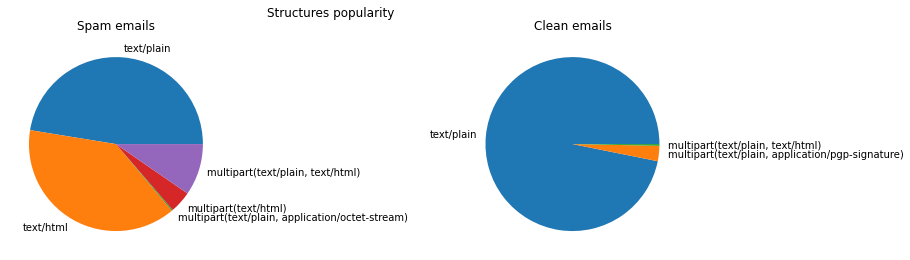

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Structures popularity')

ax1.pie(list(spam_structures.values())[:5],labels=list(spam_structures.keys())[:5])
ax1.set_title("Spam emails")
ax1.plot()

ax2.pie(list(clean_structures.values())[:3],labels=list(clean_structures.keys())[:3])
ax2.set_title("Clean emails")
ax2.plot() 

fig.set_figwidth(15)
fig.show()

As we can see in the plot above, spam emails consist mostly of plain text content while in the spam emails html and multipart structures are more common. 

In order to properly classify emails we need to use also the html text content so it has to be transformed into plain text. 

### Converting email contents to plain text

As we could see in the example and the graphs above some of the emails are formatted as HTML documents. In order to work on them we need to transform them into plain text. I will use one of the most popular python HTML parser `BeautifulSoup`.

In [17]:
print('Message Content:\n',example_spam_email.get_content())

Message Content:
 HABERDAR.COM - HABER VE MEDYA PORTALI
Art�k t�m haberleri sadece tek siteden takip edebileceksiniz. Haberdar.com a��ld�!
Haber ba�l�klar�, spor haberleri, teknoloji haberleri, k�lt�r ve sanat haberleri, internet haberleri, bilim ve uzay, 
sinema, sa�l�k...
Arad���n�z i�erik http://www.haberdar.com adresinde
Sadece t�klay�n ve haberdar olun

�������������������������������������������+,������X���'���u��9 ��8�y�������W\zYi����g�jw����~��DA���i������za�x���&��������������}�{�}�������������������������������������J+^��(�����d����x%��R���r�)z��jY��+-��(��~��{���m����X�������y�+���z����l�X��)���"����^��Z




In [18]:
from bs4 import BeautifulSoup

def html_to_plain(html_content):
    try:
        soup = BeautifulSoup(html_content, 'html.parser')
        return soup.text.replace('\n\n','')
    except:
        return "empty"


In [19]:
print(html_to_plain(example_spam_email.get_content()))

HABERDAR.COM - HABER VE MEDYA PORTALI
Art�k t�m haberleri sadece tek siteden takip edebileceksiniz. Haberdar.com a��ld�!
Haber ba�l�klar�, spor haberleri, teknoloji haberleri, k�lt�r ve sanat haberleri, internet haberleri, bilim ve uzay, 
sinema, sa�l�k...
Arad���n�z i�erik http://www.haberdar.com adresinde
Sadece t�klay�n ve haberdar olun�������������������������������������������+,������X���'���u��9 ��8�y�������W\zYi����g�jw����~��DA���i������za�x���&��������������}�{�}�������������������������������������J+^��(�����d����x%��R���r�)z��jY��+-��(��~��{���m����X�������y�+���z����l�X��)���"����^��Z


In [20]:
def parse_email(email):
    for part in email.walk():
        part_type = part.get_content_type()
        if part_type not in ['text/plain','text/html']:
            continue
        try:
            part_content = part.get_content()
        except: # in case of encoding issues
            part_content = str(part.get_payload())
        if part_type == 'text/plain':
            return part_content
        else:
            return html_to_plain(part)

In [21]:
spam_emails = [parse_email(email) for email in spam_emails]

In [22]:
clean_emails = [parse_email(email) for email in clean_emails]

### Tokenization

To use the emails content in order to train our model we need to transform the text into tokens. To acheive that I will use Python natural language processing module NLTK.

In [23]:
import nltk

stemmer = nltk.PorterStemmer()
for word in ("crash", "crashes", "crashed", "crashing"):
        print(word, "=>", stemmer.stem(word))

crash => crash
crashes => crash
crashed => crash
crashing => crash


In [24]:
import string

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))


remove_punctuation("test. test. test?")

'test test test'

In [25]:
import re
import tqdm
import numpy as np

class Tokenizer:
    def __init__(self, text_leraning_set, vocabulary_size=1000):
        self._dictionary = {}
        self._words_count = Counter()
        global_words_count = Counter()
        for email in tqdm.tqdm(text_leraning_set):
            email_word_count = self.get_words_counter(email)
            self._words_count += email_word_count
        most_frequent = self._words_count.most_common(vocabulary_size)

        for idx, element in enumerate(most_frequent):
            word, _ = element
            self._dictionary[word] = idx

    def clean_text(self, text):
        """ Prepares the text and returns the list of stemmed words """
        if text is None:
            text = 'empty'
        text = text.lower()
        text = remove_punctuation(text)
        text = re.sub("\s\s+" , " ", text)
        text = text.split(" ")
        return [stemmer.stem(word) for word in text]

    def get_words_counter(self, text):
        text = self.clean_text(text)
        return Counter(text)

    def transform(self, text):
        text = self.clean_text(text)
        words_list = self._dictionary.keys()
        result_vector = np.zeros(len(self._dictionary))
        for word in text:
            if word in words_list:
                index = self._dictionary[word]
                result_vector[index] = 1
        return result_vector


test_tokenizer = Tokenizer(["Example test sentence one", "here is another", "and next one", "Last sentence"])

100%|██████████| 4/4 [00:00<00:00, 5847.76it/s]


In [26]:
test_tokenizer._dictionary

{'sentenc': 0,
 'one': 1,
 'exampl': 2,
 'test': 3,
 'here': 4,
 'is': 5,
 'anoth': 6,
 'and': 7,
 'next': 8,
 'last': 9}

In [27]:
test_tokenizer.transform("and next one")

array([0., 1., 0., 0., 0., 0., 0., 1., 1., 0.])

Tokenizer method get_words_counter parses the text and returns dictionary of words from the text mapped to their count. Tokenizer on construction iterates through the emails and creates dictionary of size `vocabulary_size`.

In [28]:
test_email_content = clean_emails[0]

print(test_email_content)
print(test_tokenizer.get_words_counter(test_email_content))


    Date:        Wed, 21 Aug 2002 10:54:46 -0500
    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>
    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>


  | I can't reproduce this error.

For me it is very repeatable... (like every time, without fail).

This is the debug log of the pick happening ...

18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}
18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury
18:19:04 Ftoc_PickMsgs {{1 hit}}
18:19:04 Marking 1 hits
18:19:04 tkerror: syntax error in expression "int ...

Note, if I run the pick command by hand ...

delta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury
1 hit

That's where the "1 hit" comes from (obviously).  The version of nmh I'm
using is ...

delta$ pick -version
pick -- nmh-1.0.4 [compiled on fuchsia.cs.mu.OZ.AU at Sun Mar 17 14:55

In [29]:
list(test_tokenizer._dictionary.keys())[0:25]

['sentenc',
 'one',
 'exampl',
 'test',
 'here',
 'is',
 'anoth',
 'and',
 'next',
 'last']

Now lets create the leraning data set for the ML model.

In [30]:
import pandas as pd

all_emails = [*spam_emails, *clean_emails]
tokenizer = Tokenizer(all_emails)

vectors = [tokenizer.transform(email) for email in all_emails]
labels = ["spam" for _ in spam_emails]+["clean" for _ in clean_emails]

100%|██████████| 3052/3052 [00:15<00:00, 202.47it/s]


In [31]:
df = pd.DataFrame({"vector": vectors, "label": labels})

In [32]:
from sklearn.utils import shuffle

df = shuffle(df)
df.head()

,vector,label
1817,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",clean
2605,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",clean
1707,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",clean
1974,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",clean
1560,"[1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...",clean


## Keras ML Model

Now when we have the training data prepared I will prepare the train and test datasets as well as the model.

### Preparing model input

In [40]:
df.shape

(3052, 2)

In [71]:
from sklearn.model_selection import train_test_split

X = df["vector"]
Y = df["label"]

test_size_factor = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size_factor, random_state=1000)

In [72]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(Y)

y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

In [73]:
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [82]:
X_train = np.stack(np.array(X_train), axis=0)
X_test = np.stack(np.array(X_test), axis=0)

In [83]:
print("Train set size: ", len(X_train))
print("Test set size: ", len(X_test))

Train set size:  2136
Test set size:  916


### Building first model



In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [93]:
input_layer_dimension = X_train.shape[1]

model = Sequential()
model.add(layers.Dense(10, input_dim=input_layer_dimension, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [94]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                10010     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 10,021
Trainable params: 10,021
Non-trainable params: 0
_________________________________________________________________


In [95]:
history = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Epoch 1/100
214/214 [==============================] - 1s 2ms/step - loss: 0.3606 - accuracy: 0.8505 - val_loss: 0.1296 - val_accuracy: 0.9847
Epoch 2/100
214/214 [==============================] - 0s 1ms/step - loss: 0.1101 - accuracy: 0.9861 - val_loss: 0.0789 - val_accuracy: 0.9880
Epoch 3/100
214/214 [==============================] - 0s 1ms/step - loss: 0.0559 - accuracy: 0.9940 - val_loss: 0.0610 - val_accuracy: 0.9902
Epoch 4/100
214/214 [==============================] - 0s 1ms/step - loss: 0.0393 - accuracy: 0.9964 - val_loss: 0.0500 - val_accuracy: 0.9913
Epoch 5/100
214/214 [==============================] - 0s 1ms/step - loss: 0.0269 - accuracy: 0.9985 - val_loss: 0.0473 - val_accuracy: 0.9913
Epoch 6/100
214/214 [==============================] - 0s 1ms/step - loss: 0.0169 - accuracy: 0.9980 - val_loss: 0.0421 - val_accuracy: 0.9913
Epoch 7/100
214/214 [==============================] - 0s 1ms/step - loss: 0.0133 - accuracy: 0.9997 - val_loss: 0.0371 - val_accuracy: 0.9913

In [135]:
def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='training')
    plt.plot(x, val_accuracy, 'r', label='validation')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='training')
    plt.plot(x, val_loss, 'r', label='validation')
    plt.title('Loss')
    plt.legend()

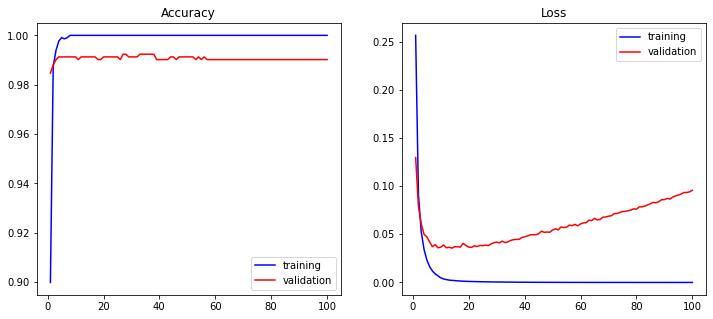

In [136]:
plot_history(history)

In [137]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.2%}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.2%}".format(accuracy))

Training Accuracy: 100.00%
Testing Accuracy:  99.02%


As you can see the accuracy on both `training` and `test` data is already very good. Let's see whether we can squeeze out something more.

## Logistic Regression

Now let's compare our previous models performance with LogisticRegresion model.

In [87]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

score = classifier.score(X_test, y_test)

print("Accuracy:", "{:.2%}".format(score))

Accuracy: 98.69%


As you can see that the logistic regression result is pretty impresive – above 95%.